# Regression Priors in DLT

This notebook demonstrates usage of priors in the regression analysis. The *iclaims* data will be used in demo purpose. Examples include

1. regression with default setting
2. regression with bounded priors for regression coefficients 

Generally speaking, regression coefficients are more robust under full Bayesian sampling and estimation.  The default setting `estimator='stan-mcmc'` will be used in this tutorial.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import orbit
from orbit.utils.dataset import load_iclaims
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data
from orbit.constants.palette import OrbitPalette

In [2]:
print(orbit.__version__)

1.1.3


## US Weekly Initial Claims

Recall the *iclaims* dataset by previous section. In order to use this data to nowcast the US unemployment claims during COVID-19 period, the dataset is extended to Jan 2021 and the [S&P 500 (^GSPC)](https://finance.yahoo.com/quote/%5EGSPC/history?period1=1264032000&period2=1611187200&interval=1wk&filter=history&frequency=1wk&includeAdjustedClose=true) and [VIX](https://finance.yahoo.com/quote/%5EVIX/history?p=%5EVIX) Index historical data are attached for the same period.

The data is standardized and log-transformed for the model fitting purpose.

In [3]:
# load data
df = load_iclaims(end_date='2021-01-03')
df = df[['week', 'claims', 'trend.unemploy', 'trend.job', 'sp500', 'vix']]
df = df[1:].reset_index(drop=True)

date_col = 'week'
response_col = 'claims'
df.dtypes

week              datetime64[ns]
claims                   float64
trend.unemploy           float64
trend.job                float64
sp500                    float64
vix                      float64
dtype: object

In [4]:
df.head(5)

,week,claims,trend.unemploy,trend.job,sp500,vix
0,2010-01-10,13.624218,0.016351,0.181862,-0.550891,0.069878
1,2010-01-17,13.398741,0.032611,0.130569,-0.590640,0.491772
2,2010-01-24,13.137549,-0.000179,0.119987,-0.607162,0.388078
3,2010-01-31,13.196760,-0.069172,0.087552,-0.614339,0.446838
4,2010-02-07,13.146984,-0.182500,0.019344,-0.605636,0.308205


We can see form the plot below, there are seasonality, trend, and as well as a huge change point due the impact of COVID-19.

Text(0.5, 1.0, 'S&P500')

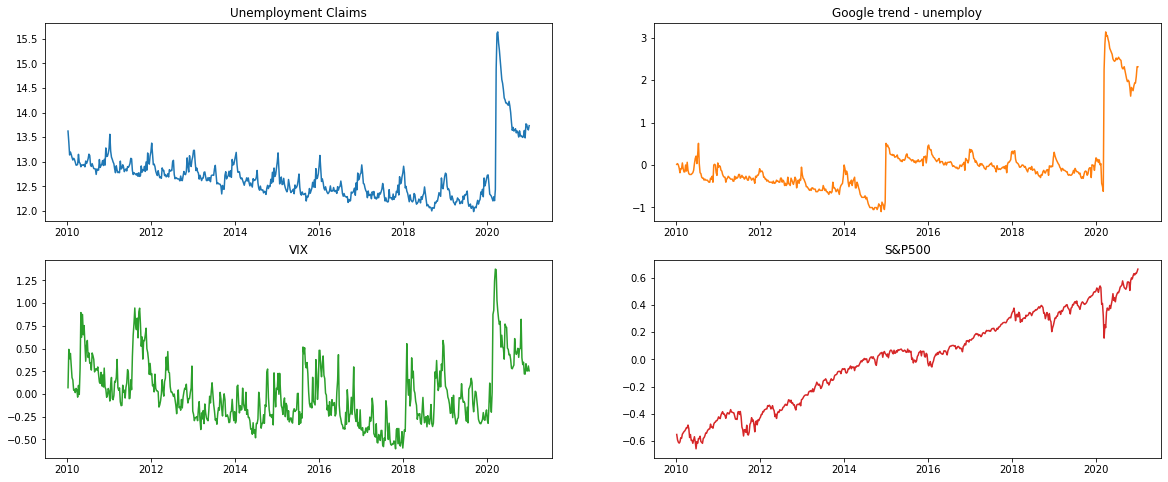

In [5]:
fig, axs = plt.subplots(2, 2,figsize=(20,8))
axs[0, 0].plot(df['week'], df['claims'])
axs[0, 0].set_title('Unemployment Claims')
axs[0, 1].plot(df['week'], df['trend.unemploy'], 'tab:orange')
axs[0, 1].set_title('Google trend - unemploy')
axs[1, 0].plot(df['week'], df['vix'], 'tab:green')
axs[1, 0].set_title('VIX')
axs[1, 1].plot(df['week'], df['sp500'], 'tab:red')
axs[1, 1].set_title('S&P500')

In [6]:
# using relatively updated data
df[['sp500']] = df[['sp500']].diff()
df = df[1:].reset_index(drop=True)

test_size = 12
train_df = df[:-test_size]
test_df = df[-test_size:]

### Naive Model

Here we will use DLT models to compare the model performance with vs. without regression.

In [7]:
%%time
dlt = DLT(
    response_col=response_col,
    date_col=date_col,
    seasonality=52,
    seed=8888,
    num_warmup=4000,
)
dlt.fit(df=train_df)
predicted_df = dlt.predict(df=test_df)

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 25.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 152 ms, sys: 108 ms, total: 260 ms
Wall time: 7.01 s


### DLT With Regression

The regressor columns can be supplied via argument `regressor_col`.  Recall the regression formula in **DLT**:

$$
\hat{y}_t =\mu_t + s_t + r_t \\
r_t = \sum_{j}\beta_j x_{jt} \\
\beta_j ~\sim \mathcal{N}(\mu_j, \sigma_j^2)
$$

By default, $\mu_j = 0$ and $\sigma_j = 1$.  In addition, we can set a *sign* constraint for each coefficient $\beta_j$.  This is can be done by supplying the `regressor_sign` as a list where elements are in one of followings:

* '=': $\beta_j ~\sim \mathcal{N}(0, \sigma_j^2)$  i.e. $\beta_j \in (-\inf, \inf)$
* '+': $\beta_j ~\sim \mathcal{N}^+(0, \sigma_j^2)$  i.e. $\beta_j \in [0, \inf)$
* '-': $\beta_j ~\sim \mathcal{N}^-(0, \sigma_j^2)$  i.e. $\beta_j \in (-\inf, 0]$

Based on some intuition, it's reasonable to assume search terms such as "unemployment", "filling" and **VIX** index to be positively correlated and stock index such as **SP500** to be negatively correlated to the outcome.  Then we will leave whatever unspecified as a regular regressor.

In [8]:
%%time
dlt_reg = DLT(
    response_col=response_col, 
    date_col=date_col,
    regressor_col=['trend.unemploy', 'trend.job', 'sp500', 'vix'],
    seasonality=52,
    seed=8888,
    num_warmup=4000,
)
dlt_reg.fit(df=train_df)
predicted_df_reg = dlt_reg.predict(test_df)

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 25.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


CPU times: user 81.1 ms, sys: 85.6 ms, total: 167 ms
Wall time: 6.96 s


The estimated regressor coefficients can be retrieved via `.get_regression_coefs()`.

In [9]:
dlt_reg.get_regression_coefs()

,regressor,regressor_sign,coefficient,coefficient_lower,coefficient_upper,Pr(coef >= 0),Pr(coef < 0)
0,trend.unemploy,Regular,0.080230,0.048558,0.106878,1.00,0.00
1,trend.job,Regular,-0.039983,-0.083835,0.009523,0.13,0.87
2,sp500,Regular,-0.010453,-0.202477,0.215410,0.42,0.58
3,vix,Regular,0.010462,-0.024078,0.036222,0.71,0.29


### Regression with Informative Priors

Due to various reasons, users may obtain further knowledge on some of the regressors or they want to propose different regularization on different regressors. These informative priors basically means to replace the defaults ($\mu$, $\sigma$) mentioned previously. In orbit, this process is done via the arguments `regressor_beta_prior` and `regressor_sigma_prior`. These two lists should be of the same length as `regressor_col`.

In addition, we can set a *sign* constraint for each coefficient $\beta_j$.  This is can be done by supplying the `regressor_sign` as a list where elements are in one of followings:

* '=': $\beta_j ~\sim \mathcal{N}(0, \sigma_j^2)$  i.e. $\beta_j \in (-\inf, \inf)$
* '+': $\beta_j ~\sim \mathcal{N}^+(0, \sigma_j^2)$  i.e. $\beta_j \in [0, \inf)$
* '-': $\beta_j ~\sim \mathcal{N}^-(0, \sigma_j^2)$  i.e. $\beta_j \in (-\inf, 0]$

Based on intuition, it's reasonable to assume search terms such as "unemployment", "filling" and **VIX** index to be positively correlated (`+` sign is used in this case) and upward shock of **SP500** (`-` sign) to be negatively correlated to the outcome. Otherwise, an unbounded coefficient can be used (`=` sign).

Furthermore, regressors such as search queries may have more direct impact than stock marker indices.  Hence, a smaller $\sigma$ is considered.

In [10]:
dlt_reg_adjust = DLT(
    response_col=response_col,
    date_col=date_col,
    regressor_col=['trend.unemploy', 'trend.job', 'sp500','vix'],
    regressor_sign=['+','=','-','+'],
    regressor_sigma_prior=[0.3, 0.1, 0.05, 0.1],
    num_warmup=4000,
    num_sample=1000,
    estimator='stan-mcmc',
    seed=2022,
)
dlt_reg_adjust.fit(df=train_df)
predicted_df_reg_adjust = dlt_reg_adjust.predict(test_df)

INFO:orbit:Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 1000 and samples(per chain): 250.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [11]:
dlt_reg_adjust.get_regression_coefs()

,regressor,regressor_sign,coefficient,coefficient_lower,coefficient_upper,Pr(coef >= 0),Pr(coef < 0)
0,trend.unemploy,Positive,0.132037,0.078566,0.210839,1.000,0.000
1,vix,Positive,0.019541,0.001662,0.054155,1.000,0.000
2,sp500,Negative,-0.030996,-0.095246,-0.003587,0.000,1.000
3,trend.job,Regular,-0.011236,-0.080350,0.060355,0.386,0.614


Let's compare the holdout performance by using the built-in function `smape()` .

In [12]:
def mae(x, y):
    return np.mean(np.abs(x - y))

naive_mae = mae(predicted_df['prediction'].values, test_df['claims'].values)
reg_mae = mae(predicted_df_reg['prediction'].values, test_df['claims'].values)
reg_adjust_mae = mae(predicted_df_reg_adjust['prediction'].values, test_df['claims'].values)

print("----------------Mean Absolute Error Summary----------------")
print("Naive Model: {:.3f}\nRegression Model: {:.3f}\nRefined Regression Model: {:.3f}".format(
    naive_mae, reg_mae, reg_adjust_mae
))

----------------Mean Absolute Error Summary----------------
Naive Model: 0.249
Regression Model: 0.249
Refined Regression Model: 0.097


## Summary

This demo showcases a use case in nowcasting. Although this may not be applicable in real-time forecasting, it mainly introduces the regression analysis with time-series modeling in `Orbit`. For people who have concerns on the forecastability, one can consider introducing lag on regressors.

Also, `Orbit` allows informative priors where sometime can be useful in combining multiple source of insights together.